Importing Libraries

In [62]:
import os
import tensorflow as tf
# For data maniplution
import pandas as pd
import numpy as np
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# for confusion Matrix and Train_test
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
from sklearn.pipeline import make_pipeline

import lightgbm as lgbm
from lightgbm import *

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from catboost import CatBoostRegressor

In [2]:
# load train dataset to dataframe
data_train = pd.read_csv('train.csv')

In [3]:
# displaying the first 10 rows
data_train.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


###Exploratory Data Analysis

In [4]:
#getting information about the train data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [5]:
# getting descriptive statistics about the train data
data_train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [6]:
# Shape of the data: number of rows and columns
data_train.shape

(5237980, 17)

In [7]:
# checking for null values
data_train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

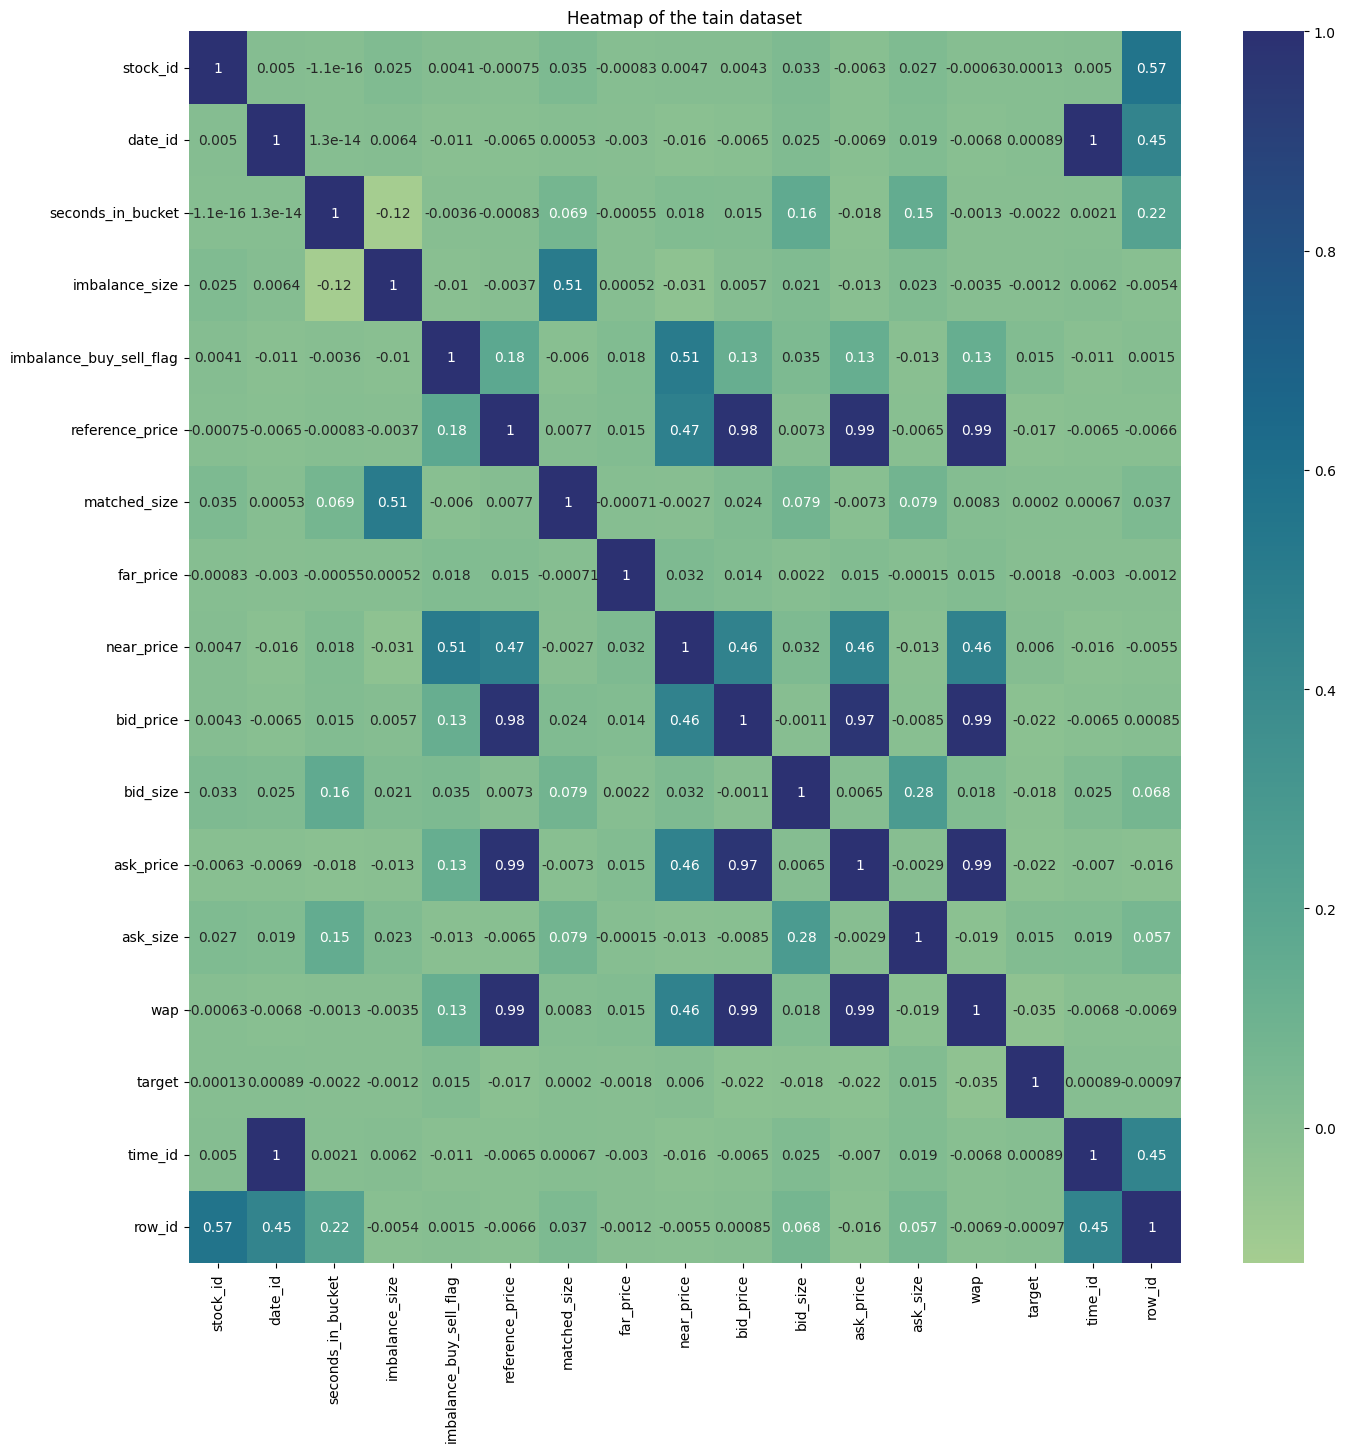

In [8]:
# plotting the heatmap for the train dataset
plt.figure(figsize=(16,16))
sns.heatmap(data_train.corr(),annot=True,cmap='crest')
plt.title('Heatmap of the tain dataset')
plt.show()

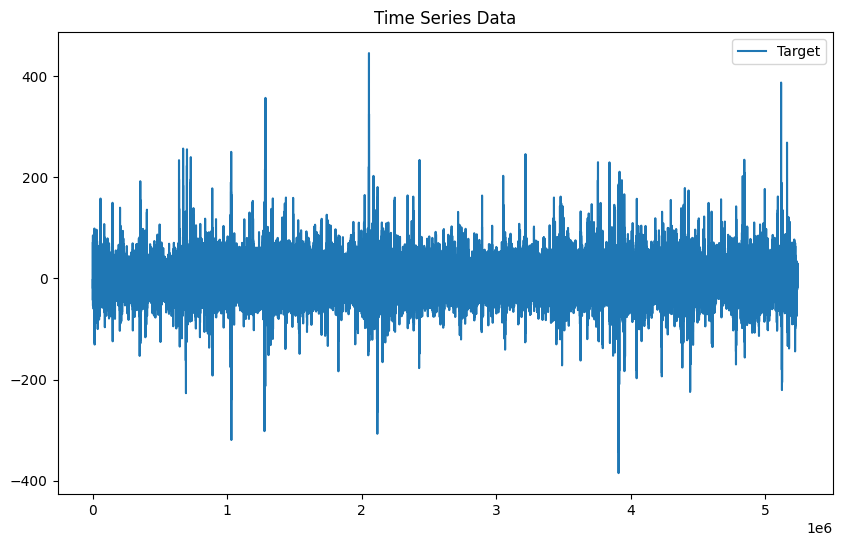

In [9]:
#Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(data_train['target'], label='Target')
plt.title('Time Series Data')
plt.legend()
plt.show()

In [10]:
# dropping all the null values and assigning it to a new dataframe
data_train_wo_na = data_train.dropna(axis=0)

In [11]:
# checking if there is still any null data present
data_train_wo_na.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [78]:
# This is one more method to deal with the missing values for all the columns with simpleImputer.
from sklearn.impute import SimpleImputer

# Save the original data types
original_dtypes = data_train.dtypes

# Create a SimpleImputer instance
imp_mean = SimpleImputer(strategy='most_frequent')

# Fit and transform the imputer on the original DataFrame
imputed_train_array = imp_mean.fit_transform(data_train)

# Convert the NumPy array back to a DataFrame
imputed_train_df = pd.DataFrame(imputed_train_array, columns=data_train.columns)

# Convert columns back to their original data types
imputed_train_df = imputed_train_df.astype(original_dtypes)

# Now, 'imputed_train_df' is your DataFrame with missing values imputed
# imputed_train_df.head(20)
imputed_train_df.info()


c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [13]:
imputed_train_df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [14]:
imputed_train_df.duplicated().sum()

0

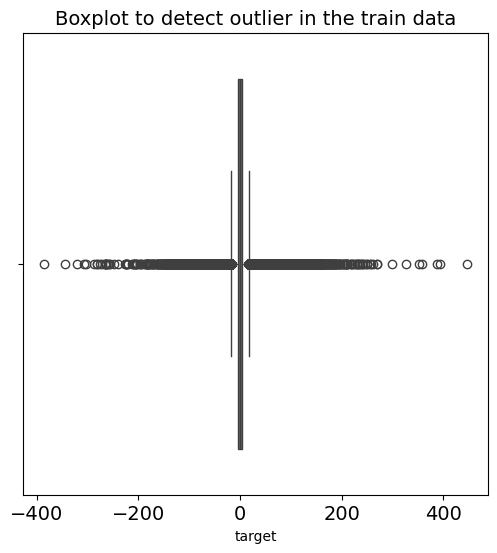

In [15]:
# checking outliers in the data
plt.figure(figsize=(6,6))
plt.title("Boxplot to detect outlier in the train data", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.boxplot(x=imputed_train_df['target'])
plt.show()

In [16]:
def find_outliers(dataframe, attribute):
    #Determine the number of rows containing outliers
    # compute the 25th percentile value in target
    percentile25 = dataframe[attribute].quantile(0.25)

    # compute the 75th percentile value in target
    percentile75 = dataframe[attribute].quantile(0.75)

    #compute the interquatile range in target
    iqr = percentile75 - percentile25

    #define upper limit and lower limit for non-outlier values
    upper_limit = percentile75 + (1.5 * iqr)
    lower_limit = percentile25 - (1.5 * iqr)
    print("Upper Limit:", upper_limit)
    print("Lower_Limit:", lower_limit)

    #identify the subset pf data containing outliers in target
    outliers = dataframe[(dataframe[attribute] > upper_limit) | (dataframe[attribute] < lower_limit)]

    # Count how many rows in the data contain outliers in `target`
    print("Number of rows in the data containing outliers in ", attribute, ":", len(outliers))


In [17]:
find_outliers(imputed_train_df, "target")

Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in  target : 292263


In [18]:
find_outliers(imputed_train_df, 'wap')


Upper Limit: 1.004701
Lower_Limit: 0.9952289999999999
Number of rows in the data containing outliers in  wap : 325523


In [79]:
# # Log transformation
imputed_log_train_df = imputed_train_df.copy()
imputed_log_train_df['target'] = np.log1p(pd.to_numeric(imputed_log_train_df['target'], errors='coerce'))
# data_train['target']= np.log1p(data_train['target'])

c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [80]:
from sklearn.preprocessing import RobustScaler

# Apply robust scaling
scaler = RobustScaler()
imputed_rob_train_df = imputed_train_df.copy()
imputed_rob_train_df['target']= scaler.fit_transform(imputed_rob_train_df['target'].values.reshape(-1, 1))


In [50]:
find_outliers(imputed_log_train_df, 'target')

Upper Limit: 4.216685820497295
Lower_Limit: -1.2466368392404341
Number of rows in the data containing outliers in  target : 93750


In [51]:
find_outliers(imputed_rob_train_df, 'target')

Upper Limit: 1.9983386497790594
Lower_Limit: -2.0016613502209406
Number of rows in the data containing outliers in  target : 292263


In [52]:
imputed_rob_train_df.nunique()

stock_id                       200
date_id                        481
seconds_in_bucket               55
imbalance_size             2971863
imbalance_buy_sell_flag          3
reference_price              28741
matched_size               2948862
far_price                    95739
near_price                   84625
bid_price                    28313
bid_size                   2591773
ask_price                    28266
ask_size                   2623254
wap                          31506
target                       15934
time_id                      26455
row_id                     5237980
dtype: int64

In [53]:
imputed_log_train_df.nunique()

stock_id                       200
date_id                        481
seconds_in_bucket               55
imbalance_size             2971863
imbalance_buy_sell_flag          3
reference_price              28741
matched_size               2948862
far_price                    95739
near_price                   84625
bid_price                    28313
bid_size                   2591773
ask_price                    28266
ask_size                   2623254
wap                          31506
target                        8289
time_id                      26455
row_id                     5237980
dtype: int64

In [54]:
print(data_train['imbalance_buy_sell_flag'].value_counts())

imbalance_buy_sell_flag
-1    2084349
 1    2022037
 0    1131594
Name: count, dtype: int64


In [81]:
imputed_train_df = imputed_train_df.drop(['row_id', 'time_id'], axis = 1)
imputed_log_train_df = imputed_log_train_df.drop(['row_id', 'time_id'], axis = 1)
imputed_rob_train_df = imputed_rob_train_df.drop(['row_id', 'time_id'], axis = 1)



imputed_train_df_X = imputed_train_df[~imputed_train_df.target.isna()]
imputed_train_df_Y = imputed_train_df_X.pop('target')

imputed_log_train_df_X = imputed_log_train_df[~imputed_log_train_df.target.isna()]
imputed_log_train_df_Y = imputed_log_train_df_X.pop('target')

imputed_rob_train_df_X = imputed_rob_train_df[~imputed_rob_train_df.target.isna()]
imputed_rob_train_df_Y = imputed_rob_train_df_X.pop('target')

seed = 69
tss = TimeSeriesSplit(10)

os.environ['PYTHONHASHSEED'] = '69'
tf.keras.utils.set_random_seed(seed)

In [86]:
print(imputed_train_df['target'].max())

def imbalance_calculator(x):
    
    list_of_features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap', 'imb_s1', 'imb_s2']
    
    x_copy = x.copy()
    
    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')
    x_copy['imb_s2'] = x.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)')
    
    list_of_prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(list_of_prices):
        for j,b in enumerate(list_of_prices):
            if i>j:
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')
                list_of_features.append(f'{a}_{b}_imb')
                    
    for i,a in enumerate(list_of_prices):
        for j,b in enumerate(list_of_prices):
            for k,c in enumerate(list_of_prices):
                if i>j and j>k:
                    max_ = x[[a,b,c]].max(axis=1)
                    min_ = x[[a,b,c]].min(axis=1)
                    mid_ = x[[a,b,c]].sum(axis=1)-min_-max_

                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    list_of_features.append(f'{a}_{b}_{c}_imb2')
    
    return x_copy[list_of_features]

ImbalanceCalculator = FunctionTransformer(imbalance_calculator)

6.102716143723309


In [83]:
def train_predict_impute(estimator, cv = tss, label = ''):
    
    X = imputed_train_df[~imputed_train_df.target.isna()]
    y = X.pop('target')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
                  
        val_predictions[val_idx] += val_preds
        
        #evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    print('Imputed Train Dataframe')
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [ ]:
models = [
    ('XGBoost', XGBRegressor(random_state = seed, objective = 'reg:absoluteerror', tree_method = 'gpu_hist', missing = np.nan)),
    ('LightGBM', LGBMRegressor(random_state = seed, objective = 'mae', device_type = 'gpu')),
    ('CatBoost', CatBoostRegressor(random_state = seed, objective = 'MAE', verbose = 0))
]

for (label, model) in models:
    _ = train_predict_impute(
        make_pipeline(
            ImbalanceCalculator,
            model
        ),
        label = label
    )